In [139]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [140]:
traindir = "C:/Users/lenovo/Desktop/test_model/Training"
validdir = "C:/Users/lenovo/Desktop//test_model/Validation"
os.listdir(traindir)

['female', 'male']

In [141]:
def show_image(dir):
    plt.figure(figsize=(12,7))
    for i in range(10):
        plt.subplot(2,5,i+1)
        img = random.choice(os.listdir(dir))
        img = load_img(os.path.join(dir,img))
        plt.subplots_adjust(hspace=0.2)
        x =dir.split("/")[-1]
        if x == "male":
            plt.suptitle("Male Images",fontsize=15)
        else:
            plt.suptitle("Female Images",fontsize=15)
        plt.imshow(img)
    plt.tight_layout()

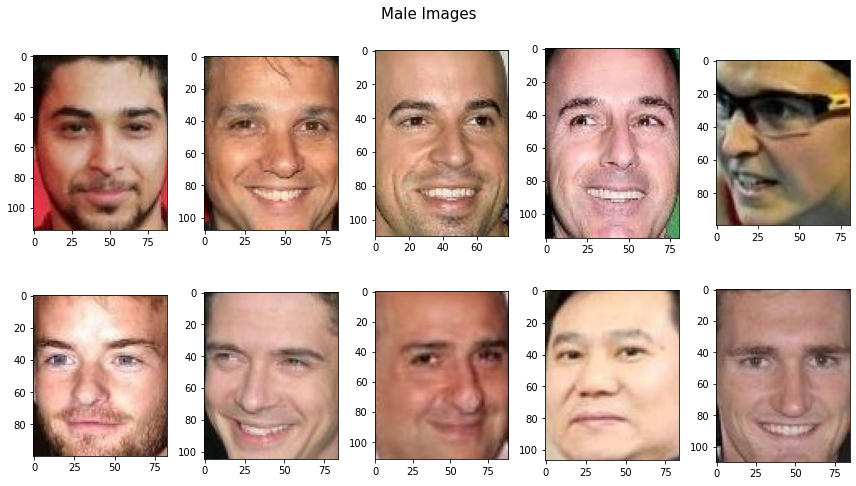

In [142]:
show_image("C:/Users/lenovo/Desktop/test_model/Training/male")

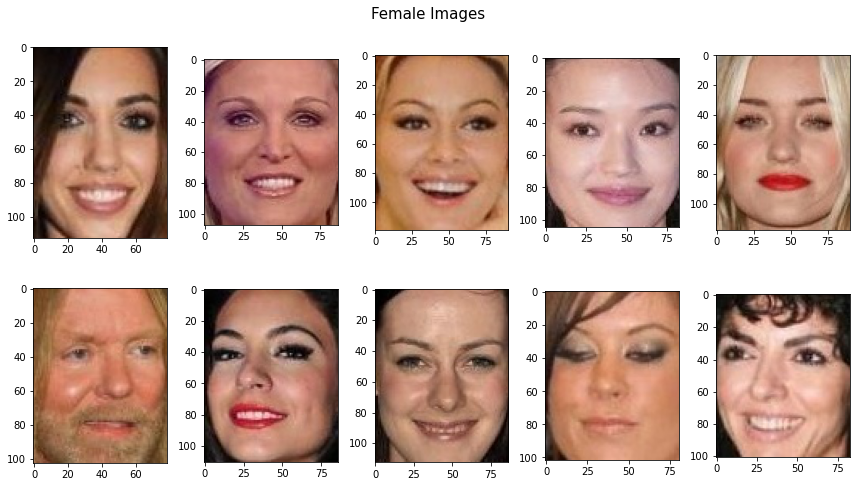

In [143]:
show_image("C:/Users/lenovo/Desktop/test_model/Training/female")

In [144]:
height = 150
width = 150
train_datagen =  ImageDataGenerator(rescale = 1/255.0,rotation_range=45,height_shift_range=0.2,shear_range=0.2,
                              zoom_range=0.2,validation_split=0.2,horizontal_flip=True)

train_data = train_datagen.flow_from_directory(directory = traindir,target_size=(height,width),
                                               class_mode = "categorical",batch_size=32,subset="training")

val_datagen = ImageDataGenerator(rescale = 1/255.0)

val_data = train_datagen.flow_from_directory(directory = traindir,target_size=(height,width),
                                               class_mode = "categorical",batch_size=32,subset="validation")

Found 37608 images belonging to 2 classes.
Found 9401 images belonging to 2 classes.


In [145]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
mobilenet = MobileNetV2(weights = "imagenet",include_top = False,input_shape=(height,width,3))

In [146]:
for layer in mobilenet.layers:
    layer.trainable = False

In [147]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten,Dense,Dropout,Conv2D,MaxPool2D,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [148]:
model = Sequential()
model.add(mobilenet)
model.add(Dense(128,activation="relu"))
#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(2,activation = "softmax"))

model.compile(optimizer=Adam(learning_rate=0.001),loss = "categorical_crossentropy",metrics =["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 dense_2 (Dense)             (None, 5, 5, 128)         163968    
                                                                 
 flatten_1 (Flatten)         (None, 3200)              0         
                                                                 
 dense_3 (Dense)             (None, 2)                 6402      
                                                                 
Total params: 2,428,354
Trainable params: 170,370
Non-trainable params: 2,257,984
_________________________________________________________________


In [149]:
model.compile(optimizer=Adam(lr=0.001),loss = "categorical_crossentropy",metrics =["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 dense_2 (Dense)             (None, 5, 5, 128)         163968    
                                                                 
 flatten_1 (Flatten)         (None, 3200)              0         
                                                                 
 dense_3 (Dense)             (None, 2)                 6402      
                                                                 
Total params: 2,428,354
Trainable params: 170,370
Non-trainable params: 2,257,984
_________________________________________________________________


In [150]:
checkpoint = ModelCheckpoint("Gender.h5",monitor = "val_accuracy",save_best_only = True,verbose=1)
earlystop = EarlyStopping(monitor='val_acc',patience=5,verbose=1)

In [151]:
batch_size = 32
history = model.fit(train_data,steps_per_epoch = len(train_data)// batch_size,epochs=15,
                              validation_data = val_data,validation_steps = len(val_data)//batch_size,
                              callbacks = [checkpoint,earlystop],verbose=1)

Epoch 1/15
36/36 [==============================] - ETA: 0s - loss: 0.8571 - accuracy: 0.7205
Epoch 1: val_accuracy improved from -inf to 0.78125, saving model to Gender.h5
36/36 [==============================] - 72s 2s/step - loss: 0.8571 - accuracy: 0.7205 - val_loss: 0.5054 - val_accuracy: 0.7812
Epoch 2/15
36/36 [==============================] - ETA: 0s - loss: 0.4619 - accuracy: 0.7995
Epoch 2: val_accuracy improved from 0.78125 to 0.79861, saving model to Gender.h5
36/36 [==============================] - 90s 3s/step - loss: 0.4619 - accuracy: 0.7995 - val_loss: 0.4109 - val_accuracy: 0.7986
Epoch 3/15
36/36 [==============================] - ETA: 0s - loss: 0.4467 - accuracy: 0.7951
Epoch 3: val_accuracy did not improve from 0.79861
36/36 [==============================] - 130s 4s/step - loss: 0.4467 - accuracy: 0.7951 - val_loss: 0.4540 - val_accuracy: 0.7639
Epoch 4/15
36/36 [==============================] - ETA: 0s - loss: 0.4351 - accuracy: 0.8186
Epoch 4: val_accuracy im

In [152]:
model.save('gender-recognisation.h5')

In [153]:
model.evaluate(val_data)

294/294 [==============================] - 263s 893ms/step - loss: 0.3210 - accuracy: 0.8640


[0.32104071974754333, 0.8639506697654724]

In [155]:
def checking(img):
    label = {0:"female",1:"male"} 
    image =cv2.imread(img)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    print(gray)
    cascade = cv2.CascadeClassifier('C:/Users/lenovo/Desktop/FACE_DETECTION/Face-Detection-OpenCV-master/data/haarcascade_frontalface_alt.xml')
    print(cascade)
    faces = cascade.detectMultiScale(gray,1.1)#1.1
    print(faces)
    for x,y,w,h in faces:
        face = image[y:y+h,x:x+w]
        face = cv2.resize(face,(150,150))
        img_scaled = face/255.0
        reshape = np.reshape(img_scaled,(1,150,150,3))
        img = np.vstack([reshape])
        result = model.predict(img)
        print(result)
        
        print(np.argmax(result))
        if np.argmax(result) == 0:
            cv2.rectangle(image,(x-10,y),(x+w,y+h),(0,255,0),4)
            cv2.rectangle(image,(x-10,y-50),(x+w,y),(255,0,0),-1)
            cv2.putText(image,label[0],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),1)
            print(str(result[0][0] * 100) + "%")
            
            
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            plt.imshow(image)
            
        
            
        elif np.argmax(result) == 1:
            cv2.rectangle(image,(x-10,y),(x+w,y+h),(0,255,0),4)
            cv2.rectangle(image,(x-10,y-50),(x+w,y),(255,0,0),-1)
            cv2.putText(image,label[1],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),2)
            print(str(result[0][1] * 100 )+ "%")
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            plt.imshow(image)
       
plt.show()
cv2.destroyAllWindows()


[[39 44 45 ... 53 56 43]
 [34 34 30 ... 56 51 65]
 [29 34 30 ... 62 57 65]
 ...
 [23 16 13 ... 15 22 25]
 [20 13 12 ... 19 16 12]
 [20 13 12 ... 20 18 15]]
<CascadeClassifier 0000025033EE4A30>
[[ 0 20 90 90]]
[[0.9989053  0.00109475]]
0
99.89053010940552%


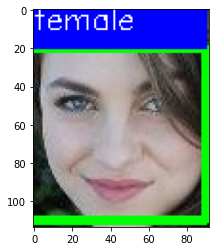

In [156]:
# image =cv2.imread('131422.jpg.jpg')
# print(image)
checking('131422.jpg.jpg')

[[251 251 251 ... 242 242 242]
 [251 251 251 ... 242 242 242]
 [250 250 251 ... 241 241 241]
 ...
 [179 178 182 ... 246 245 248]
 [183 183 177 ... 243 243 244]
 [179 175 164 ... 238 236 239]]
<CascadeClassifier 00000250370B2E90>
[[ 68  45 107 107]]
[[0.9672017  0.03279832]]
0
96.72017097473145%


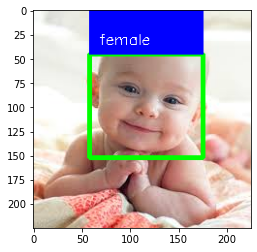

In [157]:
checking("test1.jpg")

[[58 57 61 ... 57 57 53]
 [55 58 60 ... 55 57 55]
 [52 57 61 ... 54 56 56]
 ...
 [38 39 39 ... 29 28 29]
 [38 37 37 ... 28 27 29]
 [38 36 36 ... 28 27 29]]
<CascadeClassifier 0000025033EC2690>
[[150 158 224 224]
 [978 176 202 202]
 [517 183 235 235]]
[[0.7697906 0.2302094]]
0
76.97905898094177%
[[0.4274877 0.5725124]]
1
57.25123882293701%
[[0.11612519 0.8838748 ]]
1
88.3874773979187%


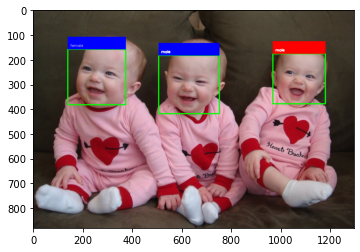

In [158]:
checking("test3.jpg")

[[206 207 208 ...  42  42  42]
 [206 207 208 ...  44  44  44]
 [206 207 208 ...  45  45  45]
 ...
 [ 45  45  45 ... 231 230 229]
 [ 45  45  45 ... 230 229 229]
 [ 45  45  45 ... 230 229 228]]
<CascadeClassifier 0000025035165530>
[[216 129 229 229]]
[[0.46025977 0.5397402 ]]
1
53.97402048110962%


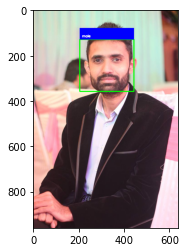

In [129]:
checking("test2.jpg")

[[251 251 251 ... 242 242 242]
 [251 251 251 ... 242 242 242]
 [250 250 251 ... 241 241 241]
 ...
 [179 178 182 ... 246 245 248]
 [183 183 177 ... 243 243 244]
 [179 175 164 ... 238 236 239]]
<CascadeClassifier 000002503521E830>
[[ 68  45 107 107]]
[[0.9672017  0.03279832]]
0
96.72017097473145%


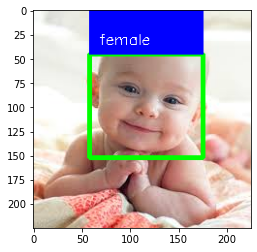

In [159]:
checking("test1.jpg")

[[206 207 208 ...  42  42  42]
 [206 207 208 ...  44  44  44]
 [206 207 208 ...  45  45  45]
 ...
 [ 45  45  45 ... 231 230 229]
 [ 45  45  45 ... 230 229 229]
 [ 45  45  45 ... 230 229 228]]
<CascadeClassifier 000002503542AF90>
[[216 129 229 229]]
[[0.46025977 0.5397402 ]]
1
53.97402048110962%


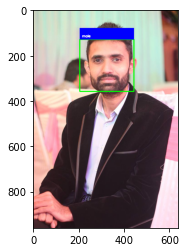

In [136]:
checking("test2.jpg")

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [253 253 254 ... 254 254 255]
 [253 253 254 ... 254 254 255]
 [254 254 254 ... 253 254 255]]
<CascadeClassifier 0000025033EC27D0>
[[63 37 96 96]]
[[0.8544701  0.14552996]]
0
85.44700741767883%


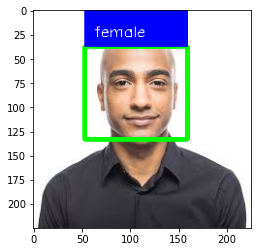

In [160]:
checking("download1.jpg")